In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shipt-delivery/TS.csv


In [13]:
!pip install chart_studio

In [14]:
import pandasql as ps

from datetime import datetime

import chart_studio.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
from plotly import figure_factory as FF
import plotly.express as px

from fbprophet import Prophet

# Objective:

Something critical to our business is understanding what <font color='red'> supply and demand might look like in the near future </font> in order to plan for hiring and shopper activation activities. Let’s say that you’ve collected the data from the ETL section for the <font color='red'> period of a year </font>:

a. How would you approach forecasting our expected daily supply and demand at the market level?

b. How would you incorporate information about the <font color='red'> spatial hierarchy </font> of supply and demand (i.e. neighborhoods roll up into a single market) and information about the “true” availability of supply (i.e. shoppers who signup but always abandon) into your forecasting method?

c. How would you evaluate the validity and accuracy of your forecast?

## Response:

### Approach:
* Frame the Problem
* Gather Necessary Data
* EDA
* Data Cleaning
* Feature Engineering
* Build Models (including SOA: Neural Prophet from FB and Hierarchical TS)
* Model Evaluation

## Frame the Problem

This is a Time Series prediction problem for supply and demand in three different markets (2 different graphs with 3 markets per graph).

## Gather Necessary Data

Year's worth of data of delivery time window start times and number of available shoppers for those windows.

In [15]:
df = pd.read_csv('../input/shipt-delivery/TS.csv')
df

,Unnamed: 0,delivery_window_id,starts_at,market_name,neighborhood_name,order_id,shopper_id,abandoned
0,0,29675515,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,881966301,2253287,0
1,1,29675516,2017-03-01T01:00:00Z,Philadelphia,Philadelphia West,882796335,2253287,0
2,2,29675517,2017-03-01T02:00:00Z,Philadelphia,Philadelphia West,882899505,2253287,0
3,3,29675518,2017-03-01T03:00:00Z,Philadelphia,Philadelphia West,883045539,2253287,0
4,4,29678563,2017-03-01T00:00:00Z,New York NY,Upper East Side,882241953,704789,1
...,...,...,...,...,...,...,...,...
2084,2084,31569629,2017-04-01T22:00:00Z,San Francisco,Financial District,944475750,3539999,0
2085,2085,31569914,2017-04-01T19:00:00Z,San Francisco,Pacific Heights / Marina,944030523,3539999,0
2086,2086,31582016,2017-04-01T22:00:00Z,Philadelphia,Chestnut Hill,944621100,2533979,0
2087,2087,31582039,2017-04-01T21:00:00Z,Philadelphia,Center City,943445190,5619176,0


For this problem, only need time stamp, demand (no of orders) and supply (no unique shoppers available who can actually fulfill orders).

In [16]:
ps.sqldf("select* from df")

,Unnamed: 0,delivery_window_id,starts_at,market_name,neighborhood_name,order_id,shopper_id,abandoned
0,0,29675515,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,881966301,2253287,0
1,1,29675516,2017-03-01T01:00:00Z,Philadelphia,Philadelphia West,882796335,2253287,0
2,2,29675517,2017-03-01T02:00:00Z,Philadelphia,Philadelphia West,882899505,2253287,0
3,3,29675518,2017-03-01T03:00:00Z,Philadelphia,Philadelphia West,883045539,2253287,0
4,4,29678563,2017-03-01T00:00:00Z,New York NY,Upper East Side,882241953,704789,1
...,...,...,...,...,...,...,...,...
2084,2084,31569629,2017-04-01T22:00:00Z,San Francisco,Financial District,944475750,3539999,0
2085,2085,31569914,2017-04-01T19:00:00Z,San Francisco,Pacific Heights / Marina,944030523,3539999,0
2086,2086,31582016,2017-04-01T22:00:00Z,Philadelphia,Chestnut Hill,944621100,2533979,0
2087,2087,31582039,2017-04-01T21:00:00Z,Philadelphia,Center City,943445190,5619176,0


In [17]:
#demand time series data
demand = ps.sqldf("select starts_at, market_name, neighborhood_name, count(order_id) from df group by 1, 2, 3")
demand

,starts_at,market_name,neighborhood_name,count(order_id)
0,2017-03-01T00:00:00Z,New York NY,Staten Island,1
1,2017-03-01T00:00:00Z,New York NY,Upper East Side,1
2,2017-03-01T00:00:00Z,Philadelphia,Chestnut Hill,1
3,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,1
4,2017-03-01T00:00:00Z,San Francisco,Financial District,1
...,...,...,...,...
2084,2017-04-01T23:00:00Z,New York NY,Downtown Brooklyn,1
2085,2017-04-01T23:00:00Z,New York NY,Staten Island,1
2086,2017-04-01T23:00:00Z,New York NY,Upper West Side,1
2087,2017-04-01T23:00:00Z,Philadelphia,Philadelphia West,1


2089 orders

In [18]:
#supply data
ps.sqldf("select starts_at, count(distinct shopper_id) from df where abandoned = 0 group by 1")

,starts_at,count(distinct shopper_id)
0,2017-03-01T00:00:00Z,3
1,2017-03-01T01:00:00Z,4
2,2017-03-01T02:00:00Z,5
3,2017-03-01T03:00:00Z,3
4,2017-03-01T04:00:00Z,2
...,...,...
502,2017-04-01T19:00:00Z,3
503,2017-04-01T20:00:00Z,4
504,2017-04-01T21:00:00Z,3
505,2017-04-01T22:00:00Z,4


507 fulfilled delivery windows by shoppers needing to do multiple orders to meet the demand.

In [19]:
#supply time series data
supply = ps.sqldf("select starts_at, market_name, neighborhood_name,count(distinct shopper_id) from df where abandoned = 0 group by 1, 2, 3")
supply

,starts_at,market_name,neighborhood_name,count(distinct shopper_id)
0,2017-03-01T00:00:00Z,New York NY,Staten Island,1
1,2017-03-01T00:00:00Z,Philadelphia,Chestnut Hill,1
2,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,1
3,2017-03-01T00:00:00Z,San Francisco,Financial District,1
4,2017-03-01T01:00:00Z,New York NY,Downtown Brooklyn,1
...,...,...,...,...
1353,2017-04-01T22:00:00Z,San Francisco,SoMa / Castro,1
1354,2017-04-01T23:00:00Z,New York NY,Downtown Brooklyn,1
1355,2017-04-01T23:00:00Z,New York NY,Staten Island,1
1356,2017-04-01T23:00:00Z,Philadelphia,Philadelphia West,1


## EDA

Let's look at supply and demand's hourly distribution.

In [20]:
supply['starts_at'] =  pd.to_datetime(supply['starts_at'],
                              format='%Y-%m-%dT%H:%M:%SZ')

In [21]:
def hrs(row):
    return row.hour
supply.starts_at.apply(hrs).value_counts(normalize=1) #relative frequencies in desc order

18    0.083211
20    0.076583
19    0.076583
21    0.075847
22    0.072901
1     0.072901
17    0.068483
16    0.065538
23    0.063328
0     0.058174
2     0.057437
15    0.053019
14    0.046392
3     0.039764
4     0.034610
13    0.027246
12    0.011046
5     0.010309
11    0.002946
6     0.002209
7     0.001473
Name: starts_at, dtype: float64

In [23]:
s = supply.starts_at.apply(hrs)
s

0        0
1        0
2        0
3        0
4        1
        ..
1353    22
1354    23
1355    23
1356    23
1357    23
Name: starts_at, Length: 1358, dtype: int64

In [24]:
fig = px.bar(x=s.value_counts().index, y=s.value_counts().values,title="Delivery Window Start Time Hours Distribution")
fig.layout.hovermode='closest'
fig.update_xaxes(title_text='Hours')
fig.update_yaxes(title_text='Count')
fig.show()

Looks like dummy data since lot of deliveries are happening in morning time. I would expect little more deliveries happening between 5 am and 11 am.

# Models
## Prophet

Let's do a first pass with Prophet and later on try out Neural Prophet for kicks :D

In [44]:
supply_df = ps.sqldf("select starts_at, count(distinct shopper_id) from df where abandoned = 0 group by 1")
supply_df

,starts_at,count(distinct shopper_id)
0,2017-03-01T00:00:00Z,3
1,2017-03-01T01:00:00Z,4
2,2017-03-01T02:00:00Z,5
3,2017-03-01T03:00:00Z,3
4,2017-03-01T04:00:00Z,2
...,...,...
502,2017-04-01T19:00:00Z,3
503,2017-04-01T20:00:00Z,4
504,2017-04-01T21:00:00Z,3
505,2017-04-01T22:00:00Z,4


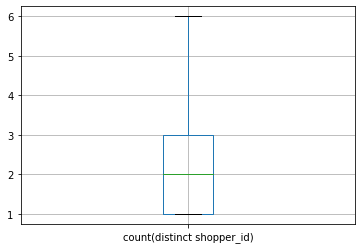

In [47]:
boxplot = supply_df.boxplot(column=['count(distinct shopper_id)'])

Median value is at 2. So expect to have mos predictons near this number and at lower end of range given boxplot.

## Data Cleaning

In [48]:
supply_df['starts_at'] = pd.to_datetime(supply_df['starts_at'],
                              format='%Y-%m-%dT%H:%M:%SZ')

In [49]:
supply_df.columns = ['ds', 'y']
supply_df.head()

,ds,y
0,2017-03-01 00:00:00,3
1,2017-03-01 01:00:00,4
2,2017-03-01 02:00:00,5
3,2017-03-01 03:00:00,3
4,2017-03-01 04:00:00,2


In [68]:
model = Prophet()
model.fit(supply_df)

ValueError: Parameter `freq` is not recognized.

In [51]:
ps.sqldf('select* from df order by 3') #month's worth only. so will start with making forecasts 30 days out 

,Unnamed: 0,delivery_window_id,starts_at,market_name,neighborhood_name,order_id,shopper_id,abandoned
0,0,29675515,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,881966301,2253287,0
1,4,29678563,2017-03-01T00:00:00Z,New York NY,Upper East Side,882241953,704789,1
2,7,29683435,2017-03-01T00:00:00Z,New York NY,Staten Island,882660162,3172091,0
3,13,29686264,2017-03-01T00:00:00Z,San Francisco,Financial District,882719499,3539999,0
4,19,29700187,2017-03-01T00:00:00Z,Philadelphia,Chestnut Hill,882721323,2253287,0
...,...,...,...,...,...,...,...,...
2084,2044,31548345,2017-04-01T23:00:00Z,New York NY,Downtown Brooklyn,943255323,3176162,0
2085,2051,31558953,2017-04-01T23:00:00Z,Philadelphia,Philadelphia West,941709711,2533979,0
2086,2068,31566801,2017-04-01T23:00:00Z,New York NY,Staten Island,944173878,3172091,0
2087,2074,31566873,2017-04-01T23:00:00Z,New York NY,Upper West Side,944763315,2831898,1


In [52]:
future = model.make_future_dataframe(periods=30)
future.tail()

,ds
532,2017-04-27 23:00:00
533,2017-04-28 23:00:00
534,2017-04-29 23:00:00
535,2017-04-30 23:00:00
536,2017-05-01 23:00:00


In [53]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
532,2017-04-27 23:00:00,2.212833,1.128662,3.485588
533,2017-04-28 23:00:00,2.218254,0.941593,3.428159
534,2017-04-29 23:00:00,2.477069,1.233558,3.620108
535,2017-04-30 23:00:00,2.259314,1.129965,3.584706
536,2017-05-01 23:00:00,2.182307,1.015271,3.439716


yhat are the predictions and most of them are 2 as expected.

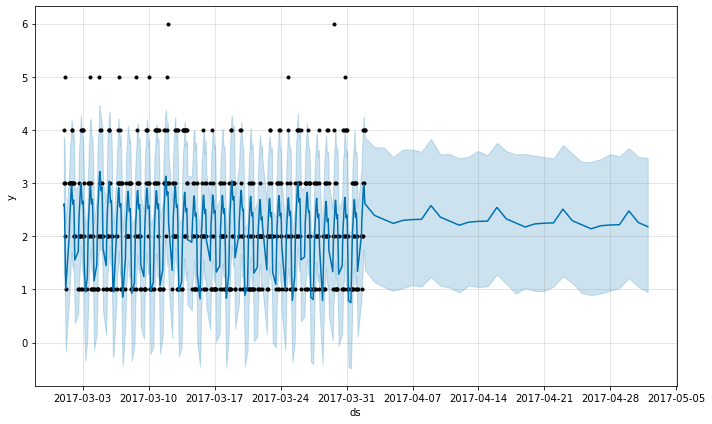

In [39]:
fig1 = model.plot(forecast)

* Black dots are the actual y values.
* Dark blue are the predictions (yhat).
* Light blue at top are yhat upper.
* Light blue at bottom are yhat lower.

Predictions are mostly between 2 and 3 with range between 1 and high end of 3's.

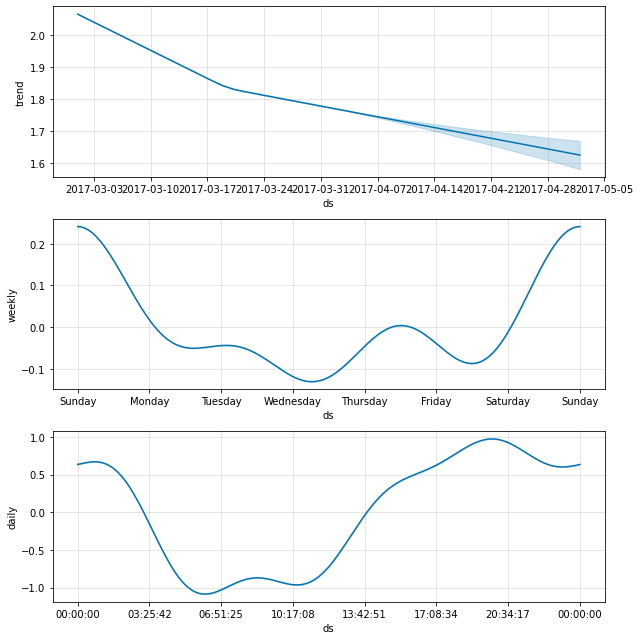

In [36]:
fig2 = model.plot_components(forecast)

* Looks like there is decline over a year's time span.
* On a weekly basis, looks lik midweek is where dip in shoppers' availability happens
* And on an hourly basis, the low end of availability is between 3 am and 1 pm as what was plotted earlier.

Now let us take a look at the prediction accuracy with some model performance reporting.

In [62]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, initial = '20 days', horizon= '10 days')

In [65]:
df_pm = performance_metrics(df_cv)
df_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 23:00:00,1.187156,1.089567,0.903312,0.420874,0.459998,0.733333
1,1 days 00:00:00,1.303777,1.141830,0.989030,0.449032,0.459998,0.666667
2,1 days 01:00:00,1.303957,1.141909,0.989481,0.449257,0.459998,0.666667
3,1 days 02:00:00,1.376829,1.173383,1.054563,0.470155,0.459998,0.666667
4,1 days 03:00:00,1.295920,1.138385,0.991815,0.438780,0.441048,0.666667
...,...,...,...,...,...,...,...
137,9 days 20:00:00,0.788837,0.888165,0.700330,0.316275,0.341041,0.800000
138,9 days 21:00:00,0.923557,0.961019,0.755634,0.325639,0.343886,0.733333
139,9 days 22:00:00,0.905068,0.951351,0.745905,0.322396,0.343886,0.733333
140,9 days 23:00:00,1.111691,1.054367,0.804531,0.329705,0.343886,0.733333


The RMSE is understable given deviation (ylower and yupper) from predictions. Though let us see if we can get an improvement through implementing Neural Prophet.

## Neural Prophet

In [66]:
!pip install neuralprophet

     |████████████████████████████████| 55 kB 304 kB/s eta 0:00:011


     |████████████████████████████████| 748.8 MB 10 kB/s s eta 0:00:01     |█████████████████████▏          | 495.3 MB 23.0 MB/s eta 0:00:12
     |████████████████████████████████| 69 kB 5.1 MB/s  eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.45.0
    Uninstalling tqdm-4.45.0:
      Successfully uninstalled tqdm-4.45.0
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.1.8 requires torch>=1.7.0, but you have torch 1.6.0 which is incompatible.


In [67]:
from neuralprophet import NeuralProphet

In [69]:
m = NeuralProphet()
metrics = m.fit(supply_df, freq="D")
future = m.make_future_dataframe(supply_df, periods=30)
forecast = m.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 63


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-05
Epoch[63/63]: 100%|██████████| 63/63 [00:06<00:00, 10.50it/s, SmoothL1Loss=1.08, MAE=5.7, RegLoss=0] 


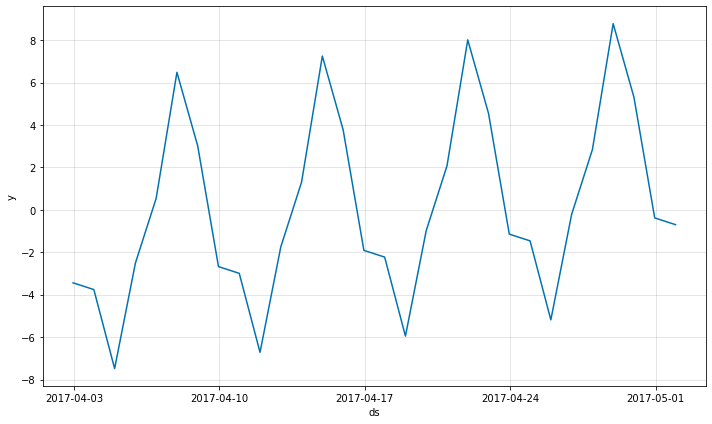

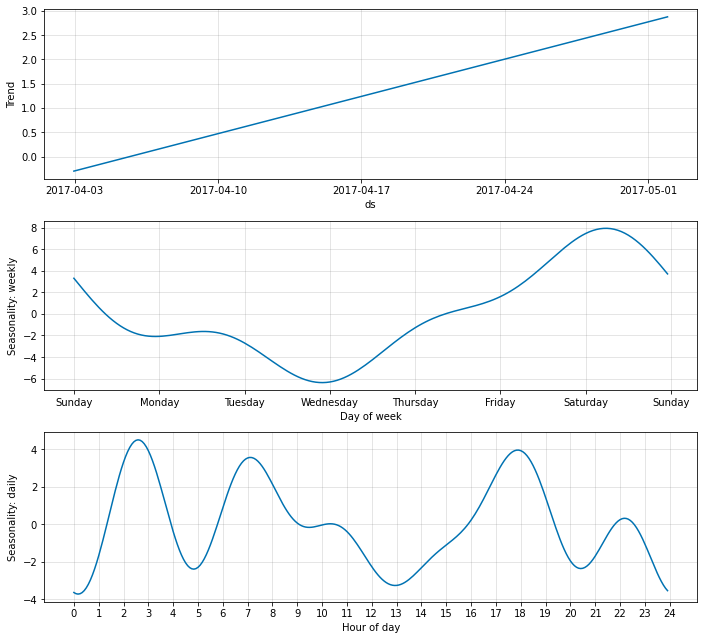

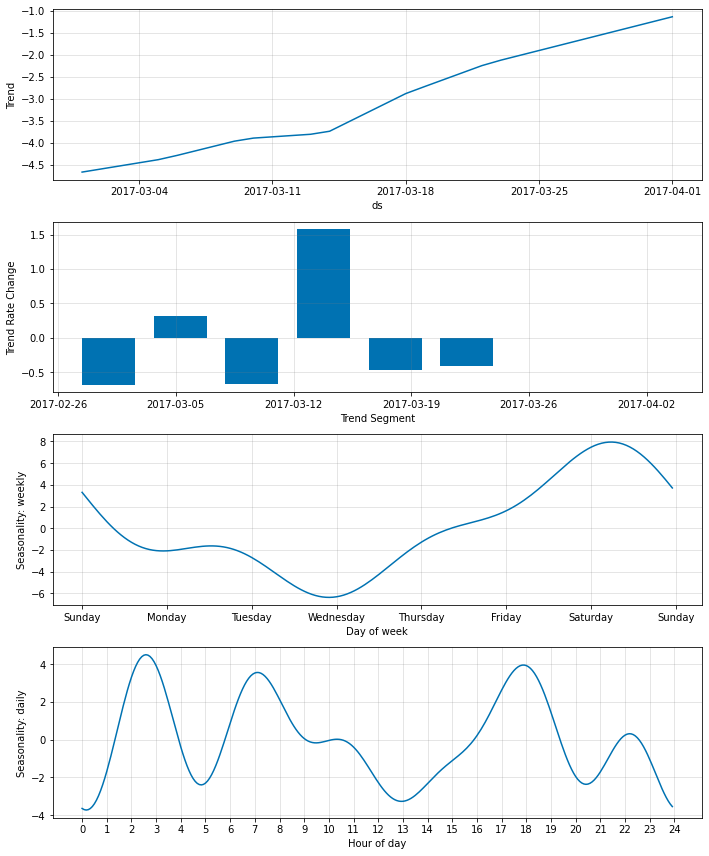

In [72]:
fig_forecast = m.plot(forecast)
fig_components = m.plot_components(forecast)
fig_model = m.plot_parameters()

* The first group of plots is for prediction (horizon) whereas the second group of plots is from the initial/training data.  

* It is clear that the Neural Net definitely captured more of the nuances in the data. Though it may have been excessive. Another thing to note is that the training data's yearly components have an upward trends whereas the normal Prophet one had downward trend. 

* Neural Prophet's week-to-week trend also predicted with greater range (up to 6). 

* Though the neural prophet captured more info, looks like the prediction may have been more off, but let us make sure with performance metrics.

In [74]:
metrics = m.fit(supply_df, freq="D", validate_each_epoch=True, valid_p=0.2)

Epoch[63/63]: 100%|██████████| 63/63 [00:05<00:00, 12.47it/s, SmoothL1Loss=0.972, MAE=5.24, RegLoss=0, MAE_val=4.57, SmoothL1Loss_val=0.788]


They used MAE here to account for outliers. So comparing regular Prophet MAE to Neural Prophet, see that MAE ranged from 0.6092029760977173 to 1.4588661228991116 whereas the Neural Prophet MAE was 5.24. Baseline Prophet was the clear winner. 

Though let us see if our forecasts can be better with other Time Series models.